## Data Exploration for NR-AhR activity in TOX21 Dataset

In this notebook we explore the TOX21 dataset (https://moleculenet.org/datasets-1) and focus on NR-AhR (Nuclear Receptor - Aryl hydrocarbon Receptor) activity. The TOX21 dataset contains 7831 samples of chemical compounds with molecular SMILES with 12 binary labels (activ/inactive) which represent the outcome of toxicological experiments. In our study we focus on one experimental outcome, i.e. whether the molecule in question activates the Aryl hydrocarbon Receptor (AhR) which is a sign for toxicity.

Here we explore the dataset and use the `rdkit` package to extract structural information about the molecules and we show how to turn it into `pytorch_geometric` graph data.

**Note:** We implemented all pre-processing steps here in a `pytorch` datasset class which is located in `dataset.py`. This notebook only serves as an introduction to the data and the pre-processing pipeline.

---

## Notebook Contents
1. [**Load Dataset**](#load): Load and dataset and prepare for exploration
2. [**Visualize Dataset**](#visualize): Visualize molecular structure of dataset
3. [**Generate graph data**](#graph): Generate graph data using `pytorch_geometric`

---

## 1. Load Dataset
<a id='load'></a>

Let us start by loading the dataset and exploring what information is contained

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the Tox21 dataset
root_dir = os.getcwd()
tox21_path = os.path.join(root_dir,'data_1/raw/tox21.csv')
df = pd.read_csv(tox21_path)

print("Dataset shape:", df.shape)
print("\nDataset columns:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset shape: (7831, 14)

Dataset columns:
['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53', 'mol_id', 'smiles']

First few rows:


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


All entries contain a `mol_id`, a `smiles` string (which encodes the molecule structure) and 12 binary experimental results for toxicity tests. The data also contains several NaN values.

Let us now focus on the NR-AhR column

NR-AhR value counts:
NR-AhR
0.0    5781
NaN    1282
1.0     768
Name: count, dtype: int64

Percentage of missing values in NR-AhR: 16.37%

Percentage of missing values in SMILES: 0.00%


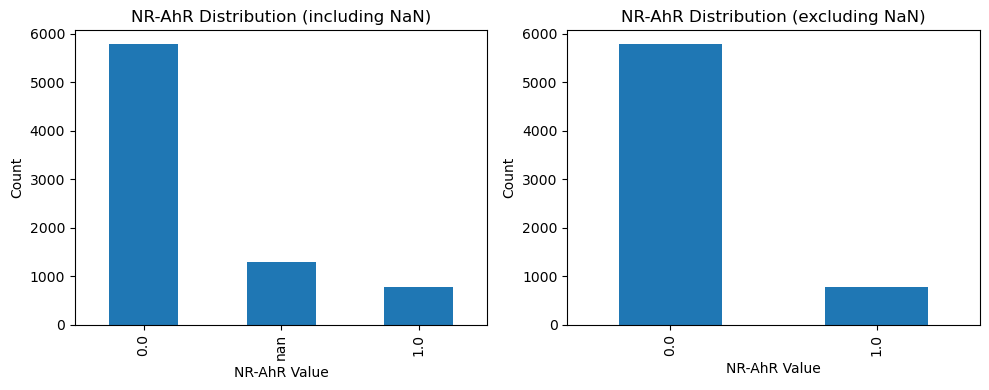

In [4]:
# Explore the NR-AhR target variable
print("NR-AhR value counts:")
print(df['NR-AhR'].value_counts(dropna=False))
print(f"\nPercentage of missing values in NR-AhR: {df['NR-AhR'].isna().sum() / len(df) * 100:.2f}%")

# Check for missing values in SMILES
print(f"\nPercentage of missing values in SMILES: {df['smiles'].isna().sum() / len(df) * 100:.2f}%")

# Visualize the distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
df['NR-AhR'].value_counts(dropna=False).plot(kind='bar')
plt.title('NR-AhR Distribution (including NaN)')
plt.xlabel('NR-AhR Value')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['NR-AhR'].dropna().value_counts().plot(kind='bar')
plt.title('NR-AhR Distribution (excluding NaN)')
plt.xlabel('NR-AhR Value')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

There is a significant class imbalance. Most samples are NR-AhR negative. For this reason we are going to use an Imbalanced Sampler for training.

In [6]:
print(f'Class 1 has a relative frequency of {(df['NR-AhR']==1).sum()/len(df['NR-AhR'].dropna())} when NAN is exlcuded.')

Class 1 has a relative frequency of 0.11726981218506642 when NAN is exlcuded.


## 2. Visualize and Pre-Process Data
<a id='visualize'></a>

As a next step we visualize a few molecules and pre-process the data to turn it into graph-like data that can be used with `torch_geometirc`

In [7]:
# Filter out rows with missing NR-AhR values or missing SMILES
df_clean = df[['smiles', 'NR-AhR']].dropna()

print(f"Original dataset size: {len(df)}")
print(f"Clean dataset size: {len(df_clean)}")
print(f"Rows removed: {len(df) - len(df_clean)}")

# Check the distribution after cleaning
print(f"\nNR-AhR distribution in clean dataset:")
print(df_clean['NR-AhR'].value_counts())

# Check for unique SMILES
print(f"\nNumber of unique SMILES: {df_clean['smiles'].nunique()}")
print(f"Number of duplicate SMILES: {len(df_clean) - df_clean['smiles'].nunique()}")

df_clean.head()

Original dataset size: 7831
Clean dataset size: 6549
Rows removed: 1282

NR-AhR distribution in clean dataset:
NR-AhR
0.0    5781
1.0     768
Name: count, dtype: int64

Number of unique SMILES: 6549
Number of duplicate SMILES: 0


,smiles,NR-AhR
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,1.0
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.0
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0
5,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0.0


Turn smiles into molecules using `rdkit` and visualize them

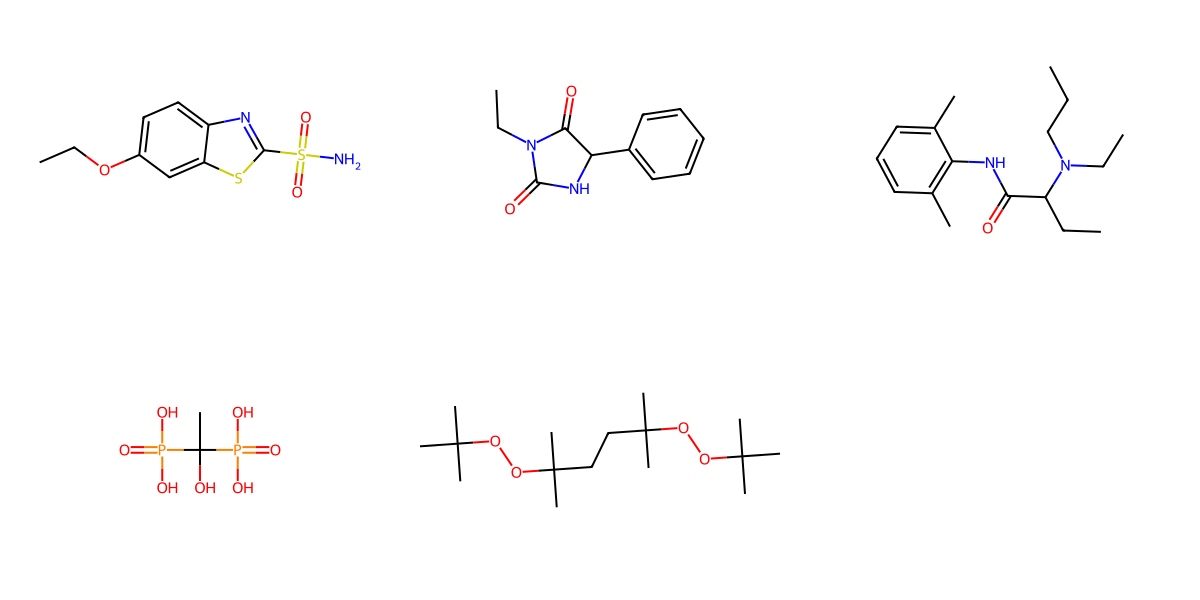

In [11]:
from rdkit.Chem import Draw, AllChem
from rdkit import Chem

example_mols = [Chem.MolFromSmiles(smiles) for smiles in df_clean[:5]['smiles']]

img = Draw.MolsToGridImage(example_mols, molsPerRow=3, subImgSize=(400,300))
img

## 3. Turn into graph data
<a id='graph'></a>

As a last step we extract information from the molecules and individual atoms to turn them into node features and edges of graphs.

In [17]:
# Mapping of bond types to integer encodings
BOND_TYPE = {
    "SINGLE": 0,
    "DOUBLE": 1,
    "TRIPLE": 2,
    "AROMATIC": 3
}

# Possible atomic numbers for atoms in dataset molecules
ATOMIC_NUMBERS = [1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 
                  26, 27, 28, 29, 30, 32, 33, 34, 35, 38, 40, 42, 46, 47, 48, 49, 50, 51, 
                  53, 56, 60, 64, 66, 70, 78, 79, 80, 81, 82, 83]

# Possible atom degrees (number of directly bonded neighbors)
ATOMIC_DEGREE = [0, 1, 2, 3, 4, 5, 6]

# Possible formal charges for atoms
ATOMIC_FORMAL_CHARGE = [-2, -1, 0, 1, 2, 3]

smiles_list = df_clean['smiles']

# Convert SMILES strings to RDKit molecule objects
rdkit_mol_objs_list = [AllChem.MolFromSmiles(s) for s in smiles_list]
labels = df_clean['NR-AhR']

[15:55:47] WARNING: not removing hydrogen atom without neighbors
[15:55:47] Explicit valence for atom # 3 Al, 6, is greater than permitted
[15:55:47] Explicit valence for atom # 4 Al, 6, is greater than permitted
[15:55:47] Explicit valence for atom # 4 Al, 6, is greater than permitted
[15:55:47] Explicit valence for atom # 9 Al, 6, is greater than permitted
[15:55:47] Explicit valence for atom # 5 Al, 6, is greater than permitted
[15:55:47] Explicit valence for atom # 16 Al, 6, is greater than permitted
[15:55:47] Explicit valence for atom # 20 Al, 6, is greater than permitted


Each molecule is turned into a graph. Every atom becomes a node in this graph and every atomic bond is an undirected edge. We additionally add node and edge features to the graph.

The node features are:
- Atomic number (one-hot encoded)
- Atomic degree (one-hot encoded)
- Atomic formal charge (one-hot encoded)
- Atom is in ring (binary, one-hot)
- Atom is aromatic (binary, one-hot)

The edge features are:
- Bond type (one-hot encoded)
- Aromatic (binary, one-hot)
- Conjugated (binary, one-hot)
- Is part of a ring (binary, one-hot)

In [28]:
from torch_geometric.data import Data
import torch
import torch_geometric

# This is the same function that is implemented in dataset.py
def mol_to_graph(mol):
    """
    Converts an RDKit molecule to a PyG Data graph.

    Args:
        mol (rdkit.Chem.Mol): RDKit molecule object.

    Returns:
        torch_geometric.data.Data: Graph representation of molecule.
    """
    # atoms
    atom_features_list = []
    edge_features_list = []
    edge_indices_list = []
        
    # Encode atom features
    for a in mol.GetAtoms():
        one_hot_atom_num = [0]*len(ATOMIC_NUMBERS)
        one_hot_atom_deg = [0]*len(ATOMIC_DEGREE)
        one_hot_atom_charge = [0]*len(ATOMIC_FORMAL_CHARGE)
        idx_num = ATOMIC_NUMBERS.index(a.GetAtomicNum())
        if idx_num >= 0:
            one_hot_atom_num[idx_num] =1
        idx_deg = ATOMIC_DEGREE.index(a.GetDegree())
        if idx_deg >= 0:
            one_hot_atom_deg[idx_deg] =1
        idx_charge = ATOMIC_FORMAL_CHARGE.index(a.GetFormalCharge())
        if idx_charge >= 0:
            one_hot_atom_charge[idx_charge] =1
        atom_features_list.append(one_hot_atom_num + one_hot_atom_deg + one_hot_atom_charge + [
            int(a.IsInRing()),
            1-int(a.IsInRing()),
            int(a.GetIsAromatic()),
            1-int(a.GetIsAromatic())
        ])
            
    x = torch.tensor(np.array(atom_features_list), dtype=torch.float)
    
    # Encode bond features
    for b in mol.GetBonds():
        one_hot_type = [0] * 4
        idx = BOND_TYPE.get(str(b.GetBondType()).upper(), -1)
        if idx >= 0:
            one_hot_type[idx] = 1
        edge_features = one_hot_type + [
            int(b.GetIsAromatic()),
            1-int(b.GetIsAromatic()),
            int(b.GetIsConjugated()),
            1-int(b.GetIsConjugated()),
            int(b.IsInRing()),
            1-int(b.IsInRing())
        ]

        # Add edges in both directions for undirected graphs
        edge_features_list.append(edge_features)
        edge_features_list.append(edge_features)
        edge_indices_list.append((b.GetBeginAtomIdx(), b.GetEndAtomIdx()))
        edge_indices_list.append((b.GetEndAtomIdx(), b.GetBeginAtomIdx()))
    
    edge_index = torch.tensor(np.array(edge_indices_list).T, dtype=torch.long)
    
    edge_attr = torch.tensor(np.array(edge_features_list),
                                    dtype=torch.float)

    
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, mol=mol)
    
    return data

Generate graph data for first molecule

In [20]:
graphData = mol_to_graph(rdkit_mol_objs_list[0])
if labels[0] == 0:
    graphData.y = torch.tensor([1,0], dtype=torch.float)
else:
    graphData.y = torch.tensor([0,1], dtype=torch.float)

In [21]:
graphData

Data(x=[16, 67], edge_index=[2, 34], edge_attr=[34, 10], mol=<rdkit.Chem.rdchem.Mol object at 0x3222b2f80>, y=[2])

In [26]:
print(f'The graph has {graphData.x.size(0)} nodes with {graphData.x.size(1)} features each.'
      f' It has {graphData.edge_index.size(1)} edges with {graphData.edge_attr.size(1)} edge attributes each'
      f' and a class label of {graphData.y}')

The graph has 16 nodes with 67 features each. It has 34 edges with 10 edge attributes each and a class label of tensor([0., 1.])


Now visualize graph with the `networkx` package

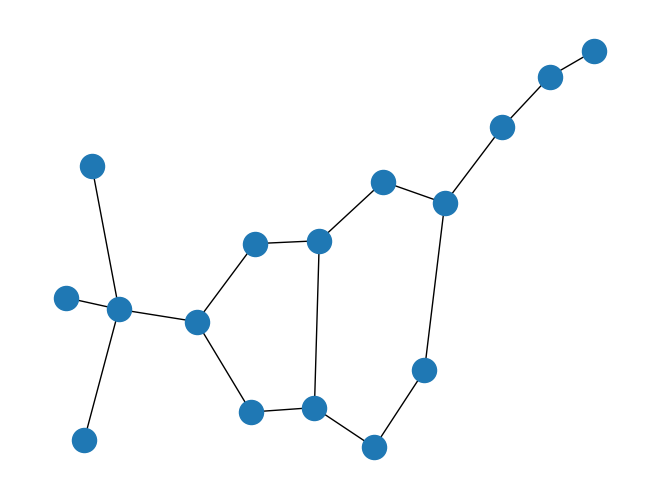

In [29]:
import networkx as nx

g = torch_geometric.utils.to_networkx(graphData, to_undirected=True)
nx.draw(g)